# CNN for Handwritten Prescription Classification

In [16]:
import kagglehub
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [17]:
# print(os.listdir(path))
# csv_path = os.path.join(path, 'Doctor’s Handwritten Prescription BD dataset')
# print(os.listdir(csv_path))
# train_path = os.path.join(csv_path, 'Training')
# print(os.listdir(train_path))
# train2 = os.path.join(train_path, 'training_words')
# print(os.listdir(train2))

In [18]:
root = kagglehub.dataset_download("mamun1113/doctors-handwritten-prescription-bd-dataset")
ds_dir = os.path.join(root, "Doctor’s Handwritten Prescription BD dataset")

train_csv = os.path.join(ds_dir, "Training",    "training_labels.csv")
train_img = os.path.join(ds_dir, "Training",    "training_words")
val_csv   = os.path.join(ds_dir, "Validation",  "validation_labels.csv")
val_img   = os.path.join(ds_dir, "Validation",  "validation_words")
test_csv = os.path.join(ds_dir, "Testing", "testing_labels.csv")
test_img = os.path.join(ds_dir, "Testing", "testing_words")

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

train_df["filepath"] = train_df["IMAGE"].apply(lambda fn: os.path.join(train_img, fn))
val_df  ["filepath"] = val_df["IMAGE"].apply(lambda fn: os.path.join(val_img, fn))
test_df["filepath"] = test_df["IMAGE"].apply(lambda fn: os.path.join(test_img, fn))

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
  dataframe    = train_df,
  x_col        = "filepath",
  y_col        = "MEDICINE_NAME",
  target_size  = (128,128),
  batch_size   = 64,
  class_mode   = "categorical",
  shuffle      = True,
  seed         = 42
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe    = val_df,
    x_col        = "filepath",
    y_col        = "MEDICINE_NAME",
    target_size  = (128,128),
    batch_size   = 64,
    class_mode   = "categorical",
    shuffle      = False
)


test_gen = val_test_datagen.flow_from_dataframe(
    dataframe   = test_df,
    x_col       = "filepath",
    y_col       = "MEDICINE_NAME",
    target_size = (128,128),
    batch_size  = 32,
    class_mode  = "categorical",
    shuffle     = False
)


Found 3120 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.


In [19]:
def build_vgg_model():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )

    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(78, activation='softmax')  # 78 classses
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
# def build_vgg2_model():
#     base_model = VGG16(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(128, 128, 3)
#     )

#     base_model.trainable = True
#     for layer in base_model.layers[:-4]:      # ufreeze final 4 layers
#         layer.trainable = False

#     return Sequential([
#         base_model,
#         Flatten(),
#         Dense(256, activation='relu'),        # 2x da capacity
#         Dropout(0.5),
#         Dense(78, activation='softmax')
#     ])

# If performance is poor:

# unfreeze some VGG16 layers --> fine-tuning
# adj classifier arcg ---- more dense layers?

In [22]:
vgg_model = build_vgg_model()
vgg_model.summary()
epochs = 100

history = vgg_model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 78)             │        10,062 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,773,454 (60.17 MB)

 Trainable params: 1,058,766 (4.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 0.0169 - loss: 8.3512 - val_accuracy: 0.0231 - val_loss: 4.2802
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - accuracy: 0.0194 - loss: 4.3132 - val_accuracy: 0.0321 - val_loss: 4.2405
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accuracy: 0.0240 - loss: 4.2956 - val_accuracy: 0.0551 - val_loss: 4.1557
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - accuracy: 0.0299 - loss: 4.2964 - val_accuracy: 0.0679 - val_loss: 4.1132
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.0350 - loss: 4.2732 - val_accuracy: 0.0833 - val_loss: 4.0741
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.0454 - loss: 4.2326 - val_accuracy: 0.0962 - val_loss: 4.0124
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.0542 - loss: 4.1872 - val_accuracy: 0.0910 - val_loss: 4.0076
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step - accuracy: 0.0524 - loss: 4.1676 - 

In [23]:
loss, acc = vgg_model.evaluate(val_gen)
print(f"Validation accuracy: {acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1940 - loss: 3.3604
Validation accuracy: 0.2308


In [27]:
test_loss, test_acc = vgg_model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.1337 - loss: 3.8785
Test Loss: 3.8517
Test Accuracy: 0.1282


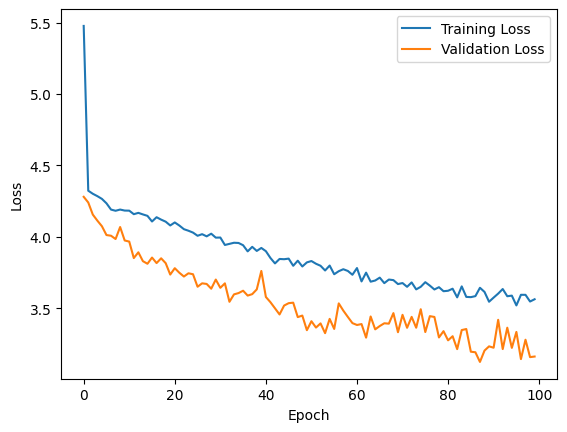

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

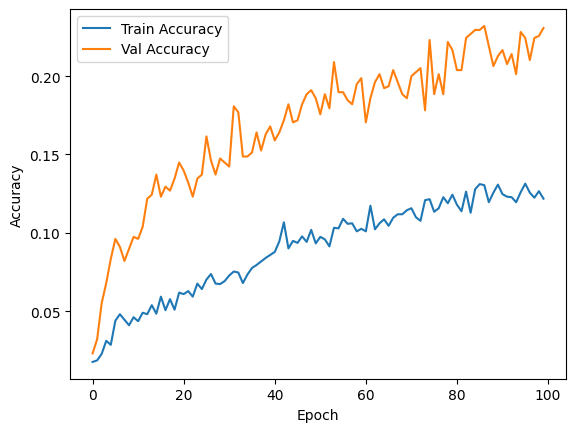

In [26]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()